In [ ]:
# Import libraries
import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from wkmeans import WKMeans

In [ ]:
# Parameters
# 1. Data range
ticker_period = '5y'
# 2. Tickers
crypto_tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD']
# 3. The number of clusters
k = 3

In [ ]:
# Data upload
df = yf.download(crypto_tickers, period = ticker_period, auto_adjust=True)

[*********************100%***********************]  3 of 3 completed


# Visualizations

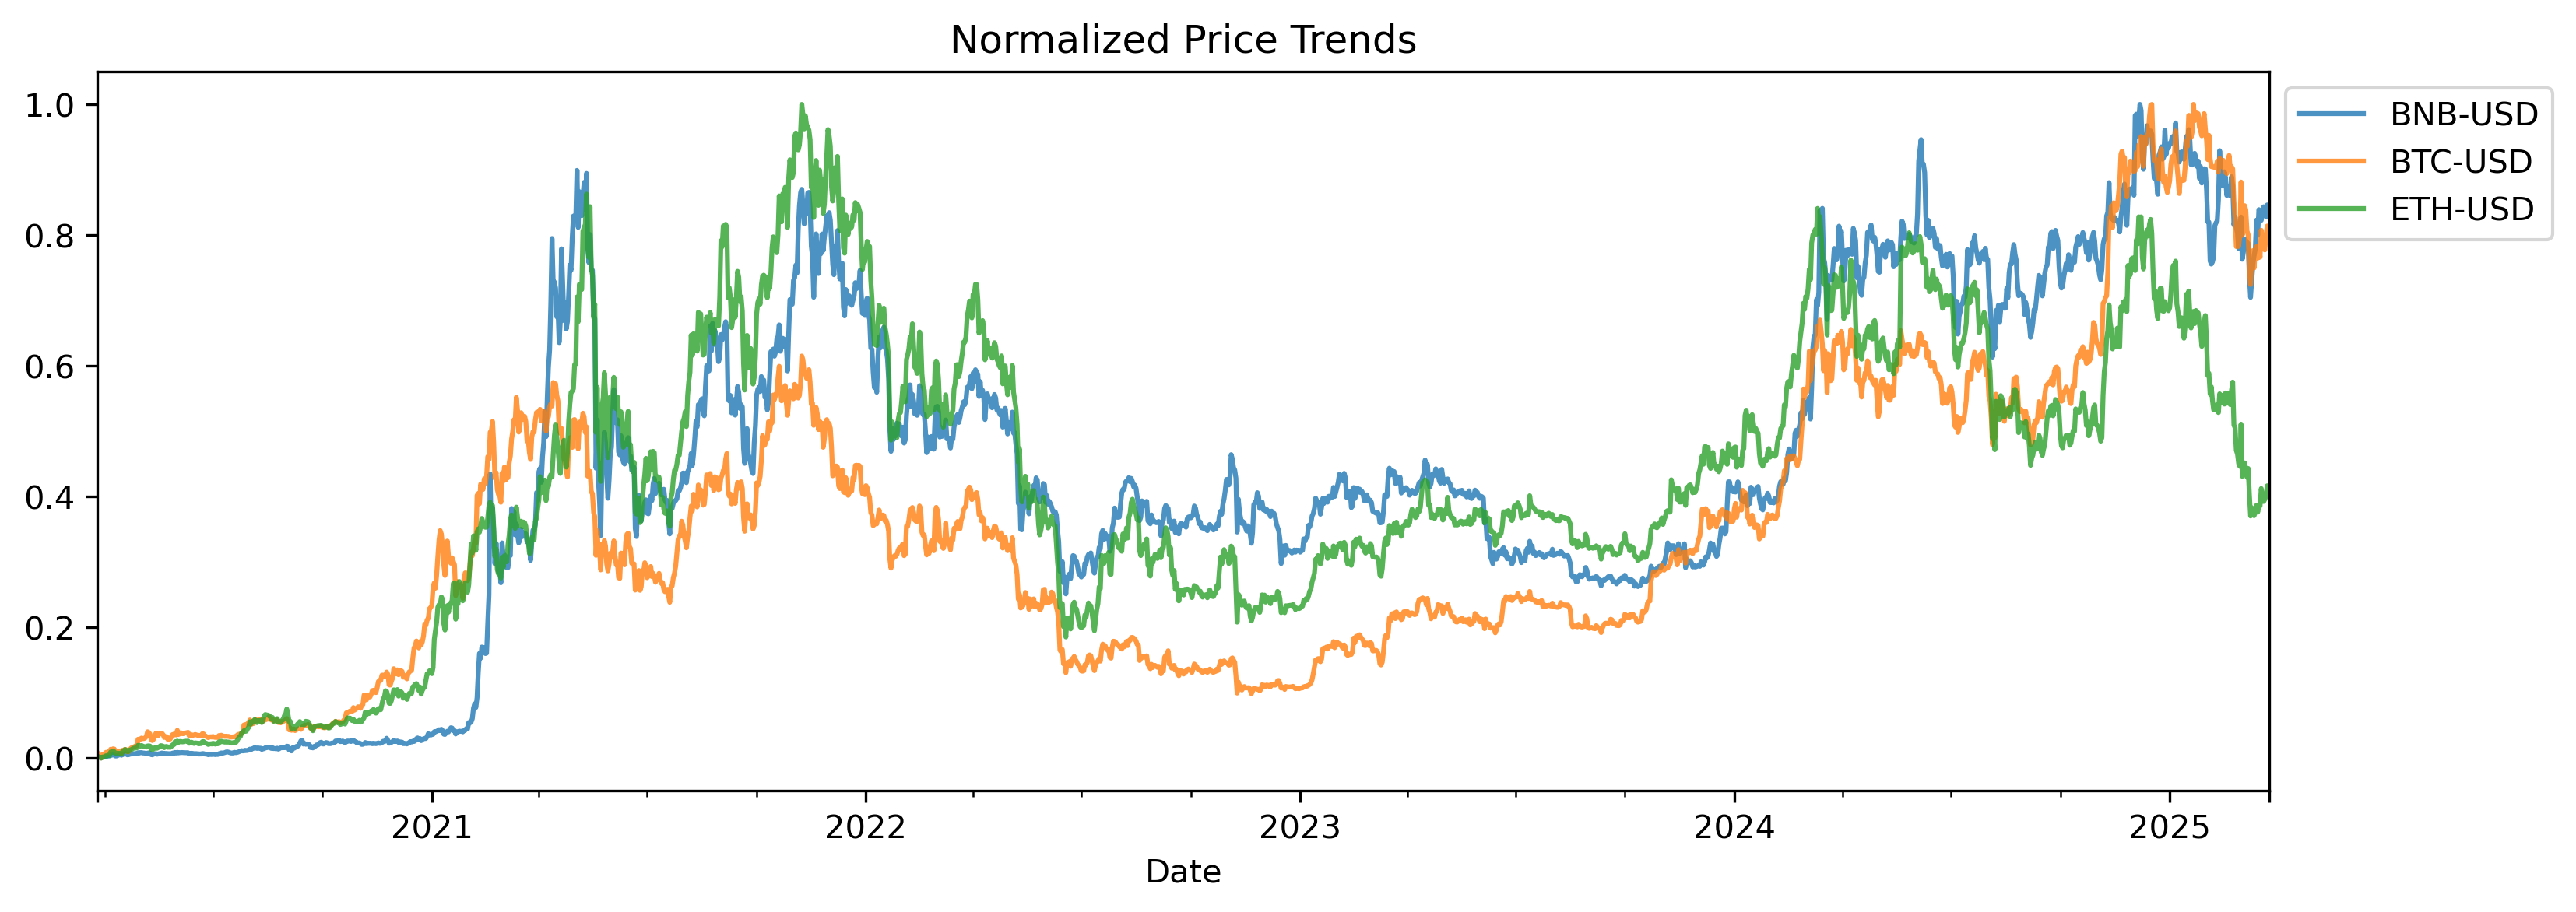

In [4]:
# Trends
df_graph = df[( 'Close',  )].copy()

for col in  df_graph.columns:
    df_graph[col] = (df_graph[col]-df_graph[col].min())/ (df_graph[col].max() - df_graph[col].min())

fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
df_graph.plot(ax=ax,  alpha=0.8)
ax.set_title('Normalized Price Trends')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

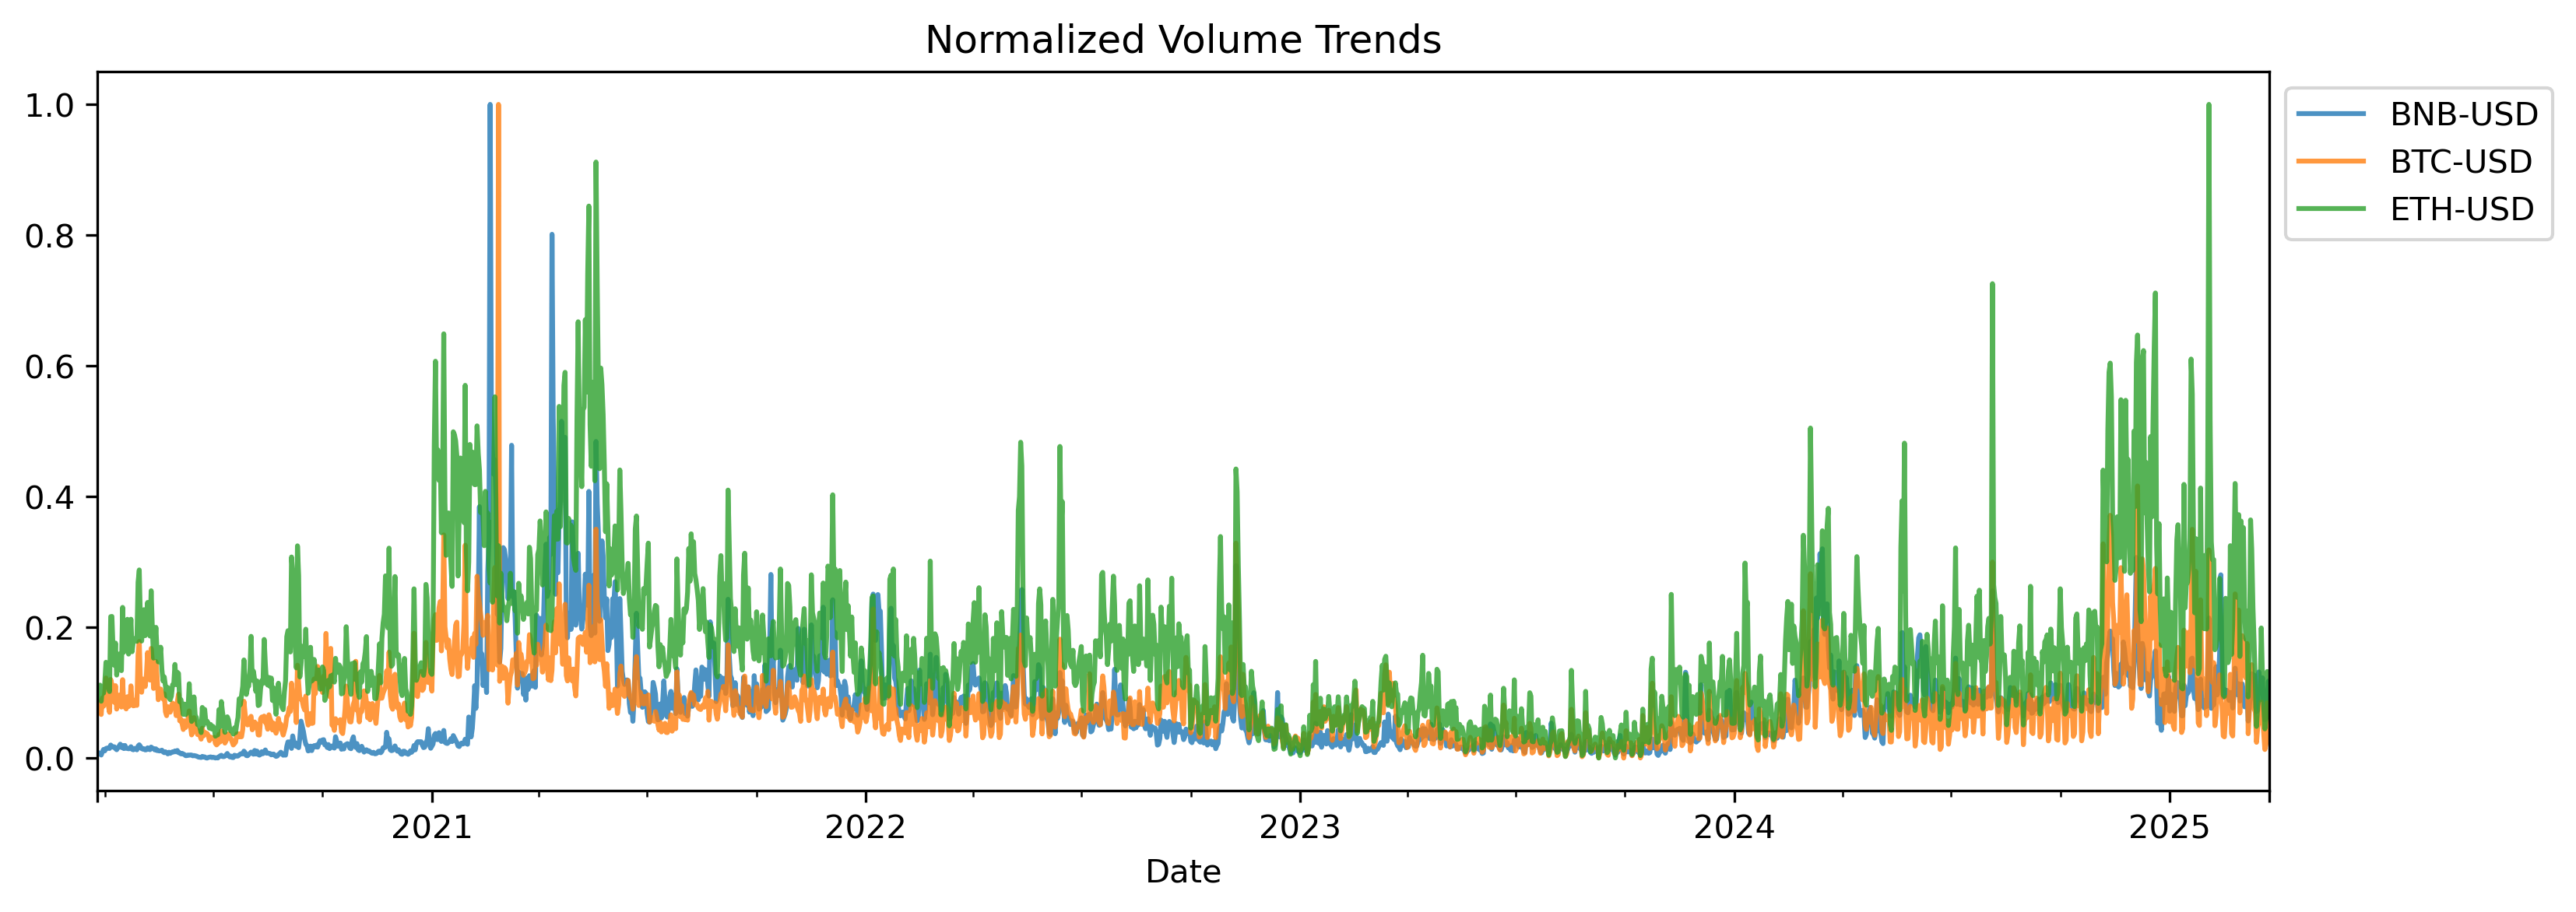

In [5]:
# Trends
df_graph = df[( 'Volume',  )].copy()

for col in  df_graph.columns:
    df_graph[col] = (df_graph[col]-df_graph[col].min())/ (df_graph[col].max() - df_graph[col].min())

fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
df_graph.plot(ax=ax,  alpha=0.8)
ax.set_title('Normalized Volume Trends')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Feature calculations

In [6]:
df_features = pd.DataFrame(index=df.index)

# 1. Returns
for ticker in crypto_tickers:
    df_features[( 'Returns',  ticker)] = np.log(df[( 'Close',  ticker)] / df[( 'Close',  ticker)].shift())

# 2. Volatility and MA
for ticker in crypto_tickers:
    for ma in [5, 10, 15, 30, 60, 180]:
        df_features[( 'MA'+str(ma),  ticker)] = df_features[( 'Returns',   ticker)].rolling(window=ma, min_periods=1).mean()
    for ma in [15, 60, 180]:
        df_features[( 'Volatility'+str(ma),  ticker)] = df_features[( 'Returns',   ticker)].rolling(window=ma, min_periods=1).std()

df_features.columns = pd.MultiIndex.from_tuples(df_features.columns, names=('feature', 'ticker'))
df_features = df_features.dropna()

# Clustering

In [7]:
# Define dataset
dataset = df_features.values

# Run k-means
kmeans=KMeans(n_clusters=k)
kmeans.fit(dataset)

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
df_features['cluster'] = kmeans.predict(dataset).tolist()
df_features['wk'] = wkmeans.predict(dataset)

# Results

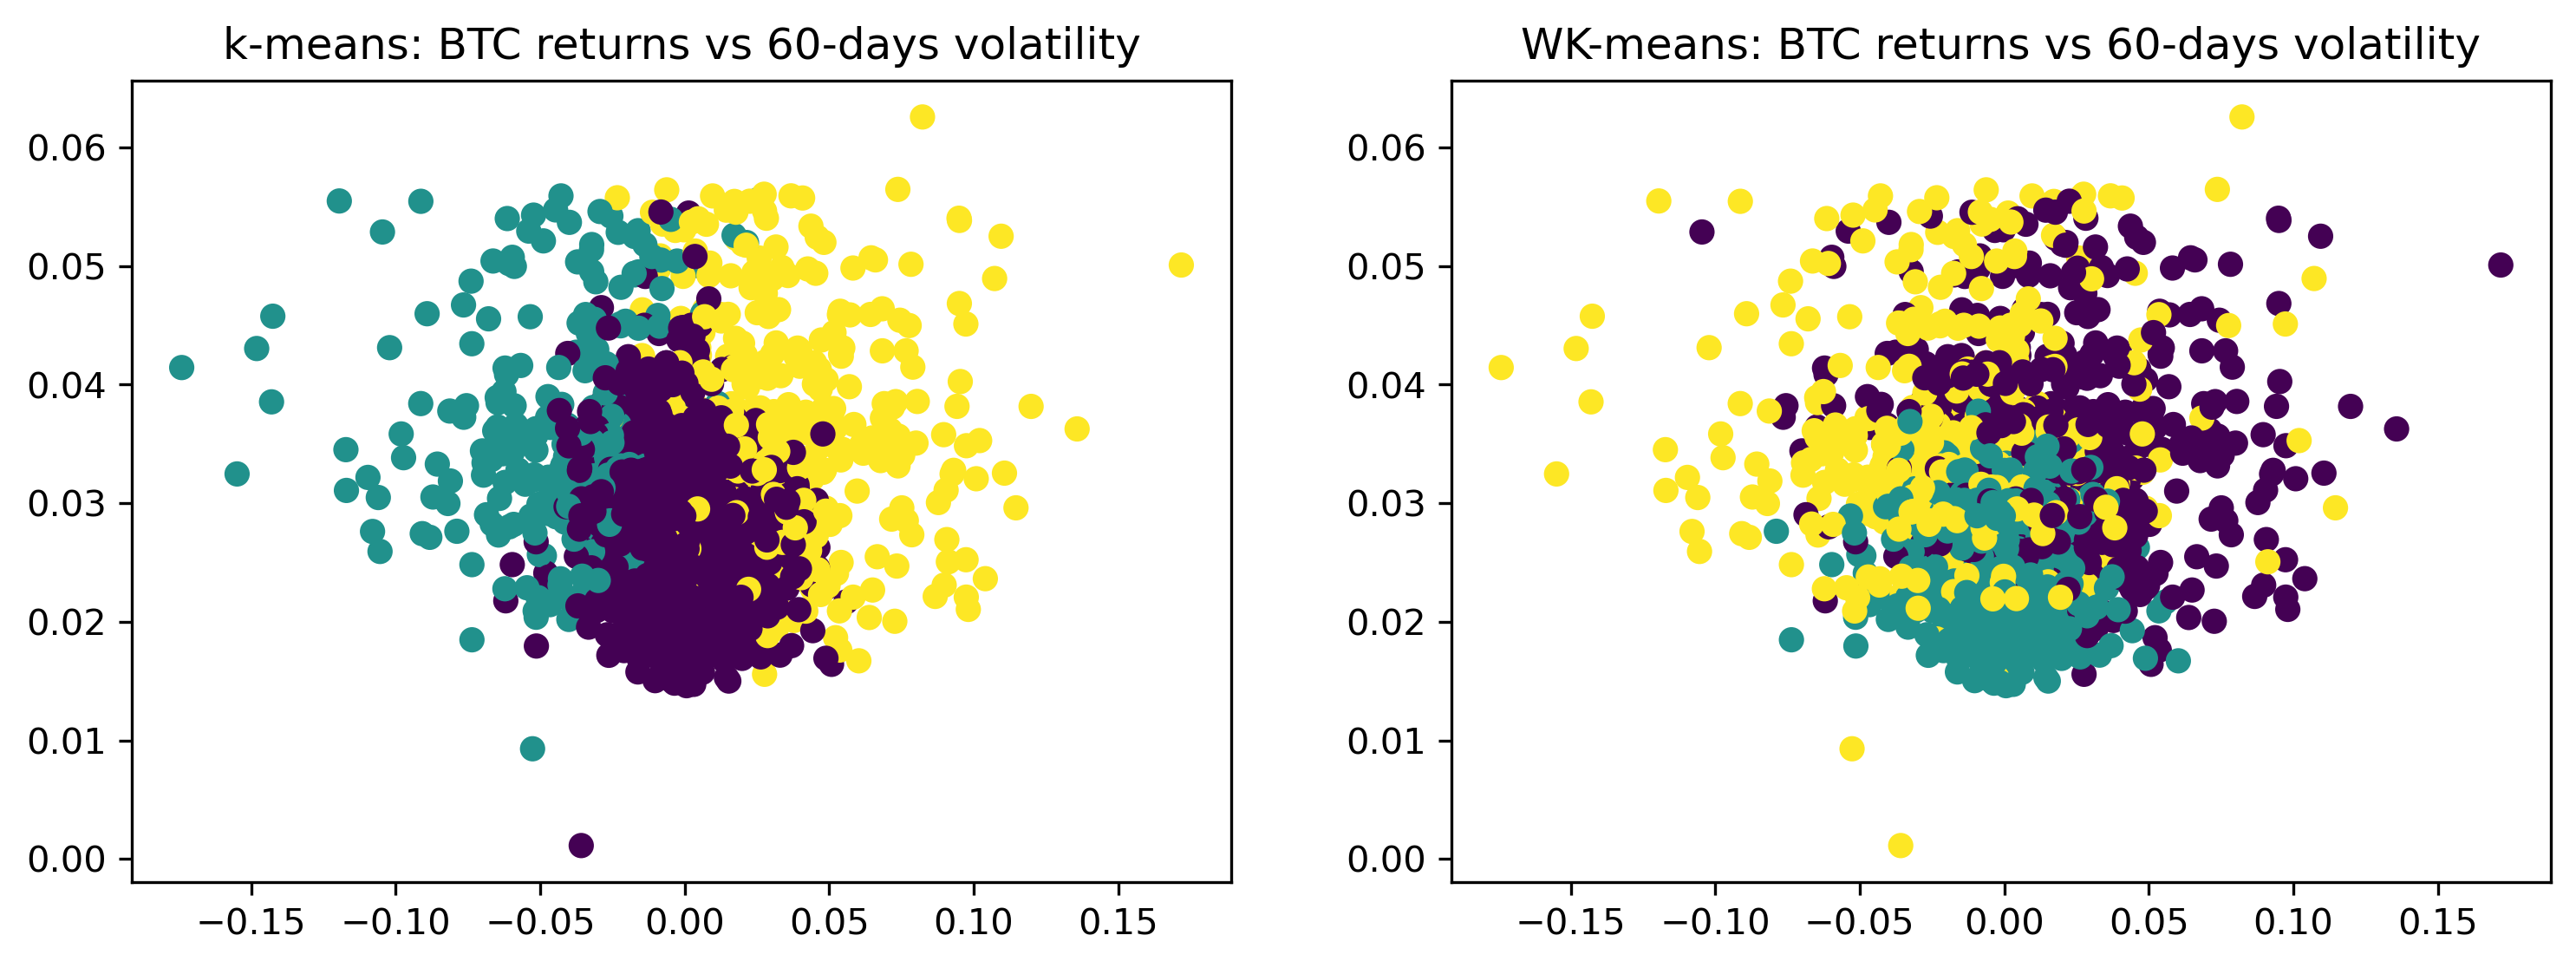

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(12, 4))

axes[0].scatter(df_features[('Returns', 'BTC-USD')].values, 
            df_features[('Volatility60', 'BTC-USD')].values,
            c=df_features['cluster'].values)

axes[0].set_title('k-means: BTC returns vs 60-days volatility')

axes[1].scatter(df_features[('Returns', 'BTC-USD')].values, 
            df_features[('Volatility60', 'BTC-USD')].values,
            c=df_features['wk'].values)

axes[1].set_title('WK-means: BTC returns vs 60-days volatility')
plt.show()

/var/folders/z_/0_qc90g95sg7r4p7j_2lxchr0000gn/T/ipykernel_17474/3353460219.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(df[('Close', 'BTC-USD')][i:i+2], color=cmap(norm(df['cluster'][i])), linewidth=2)


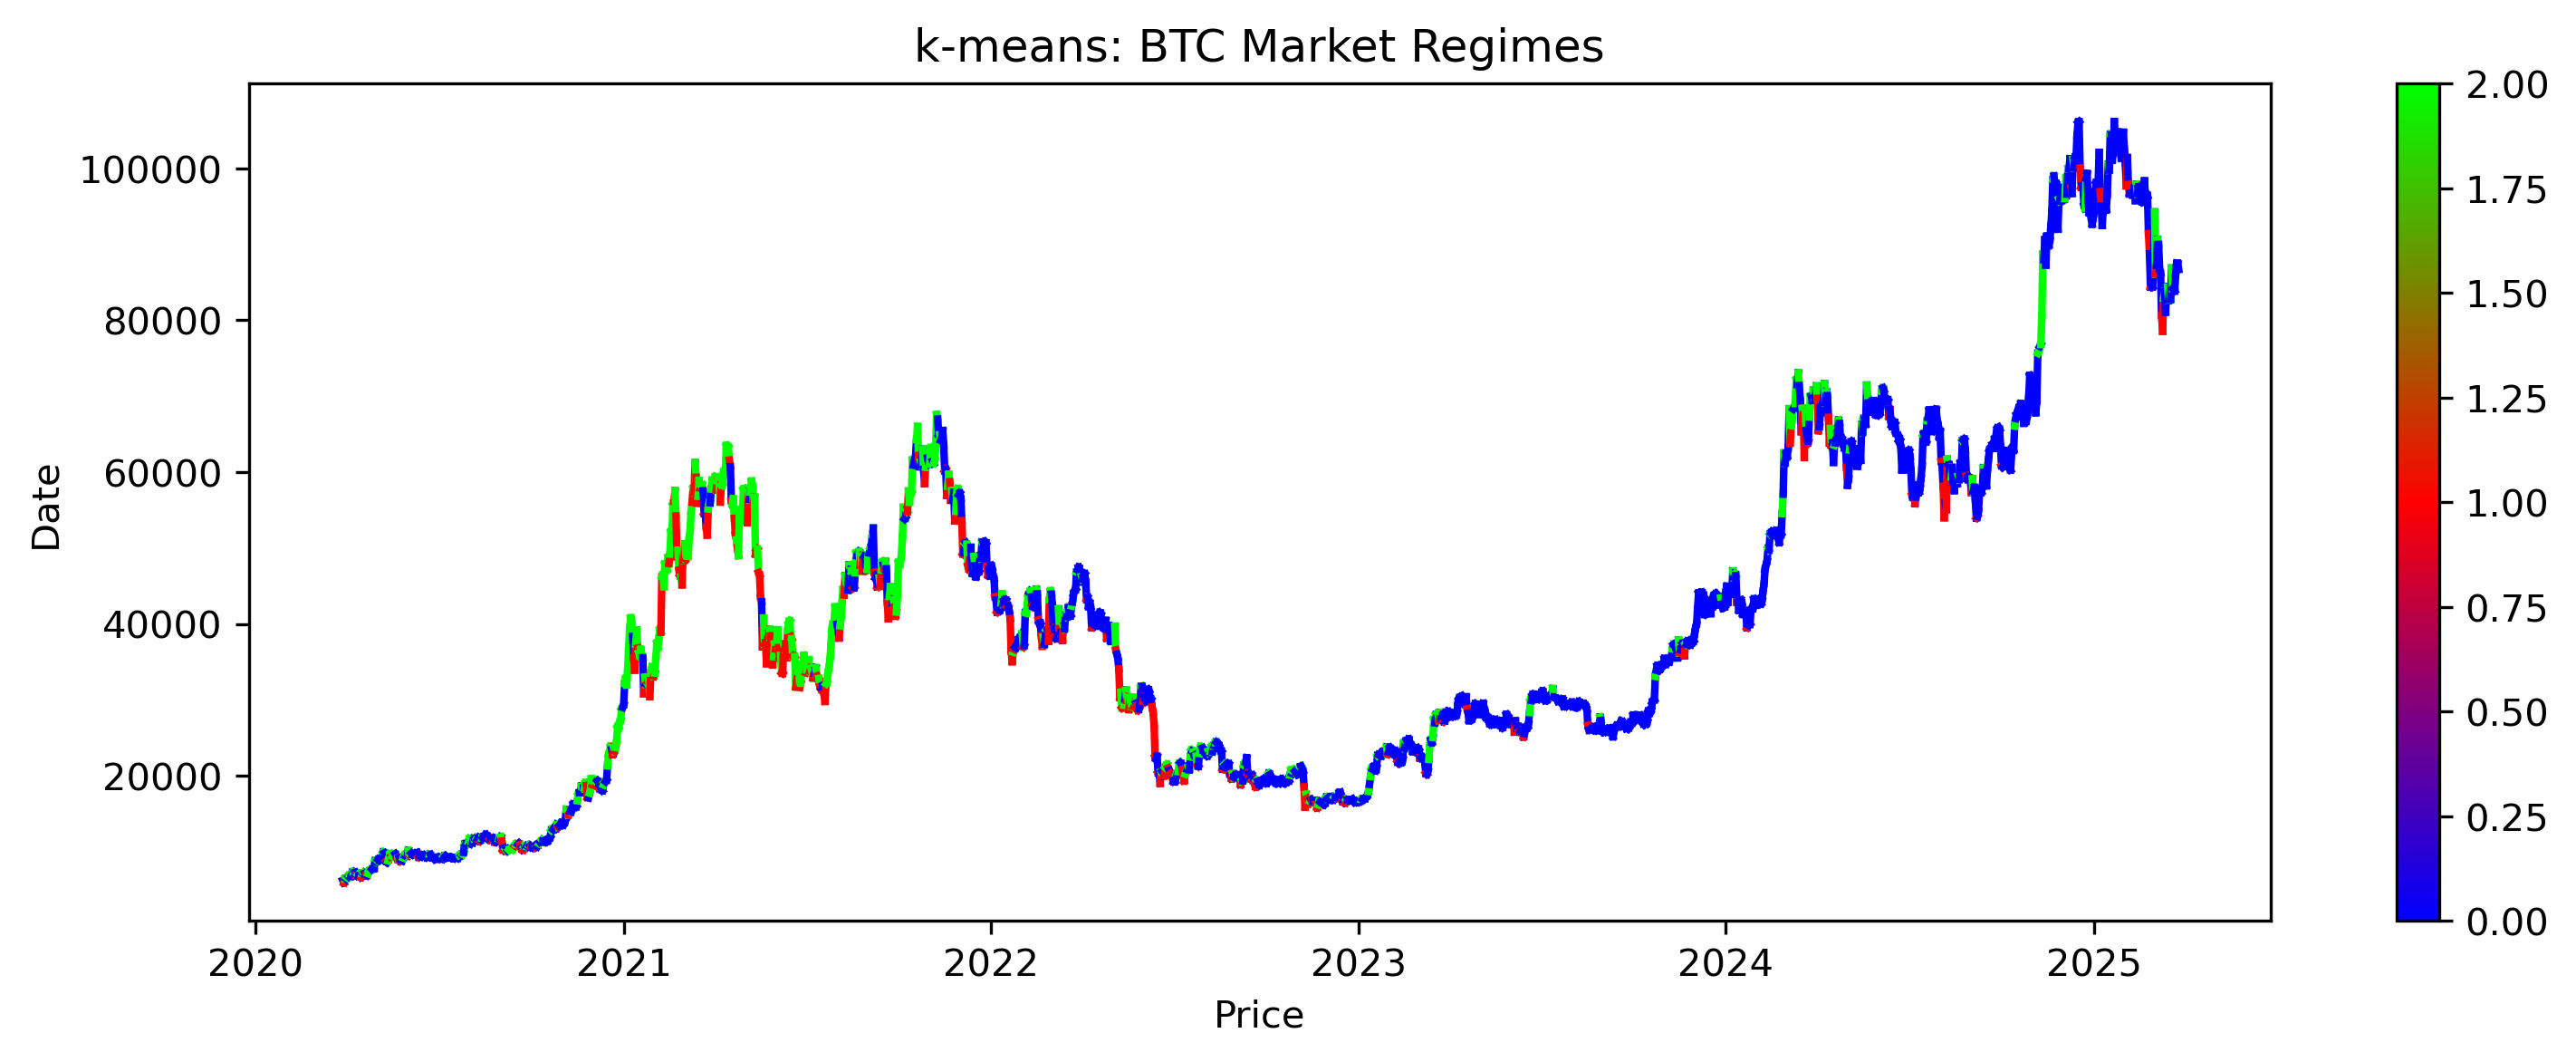

In [9]:
df = pd.concat([df, df_features['cluster']], axis=1)

n = len(df)
# Normalize color values for better visualization
norm = plt.Normalize(df['cluster'].min(), df['cluster'].max())
cmap = plt.cm.brg  # Choose a colormap (e.g., 'viridis', 'coolwarm', 'jet')

# Plot line with dynamic coloring
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
for i in range(n - 1):
    ax.plot(df[('Close', 'BTC-USD')][i:i+2], color=cmap(norm(df['cluster'][i])), linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Labels and title
ax.set_xlabel("Price")
ax.set_ylabel("Date")
ax.set_title("k-means: BTC Market Regimes")

plt.show()


/var/folders/z_/0_qc90g95sg7r4p7j_2lxchr0000gn/T/ipykernel_17474/2982049186.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(df[('Close', 'BTC-USD')][i:i+2], color=cmap(norm(df['wk'][i])), linewidth=2)


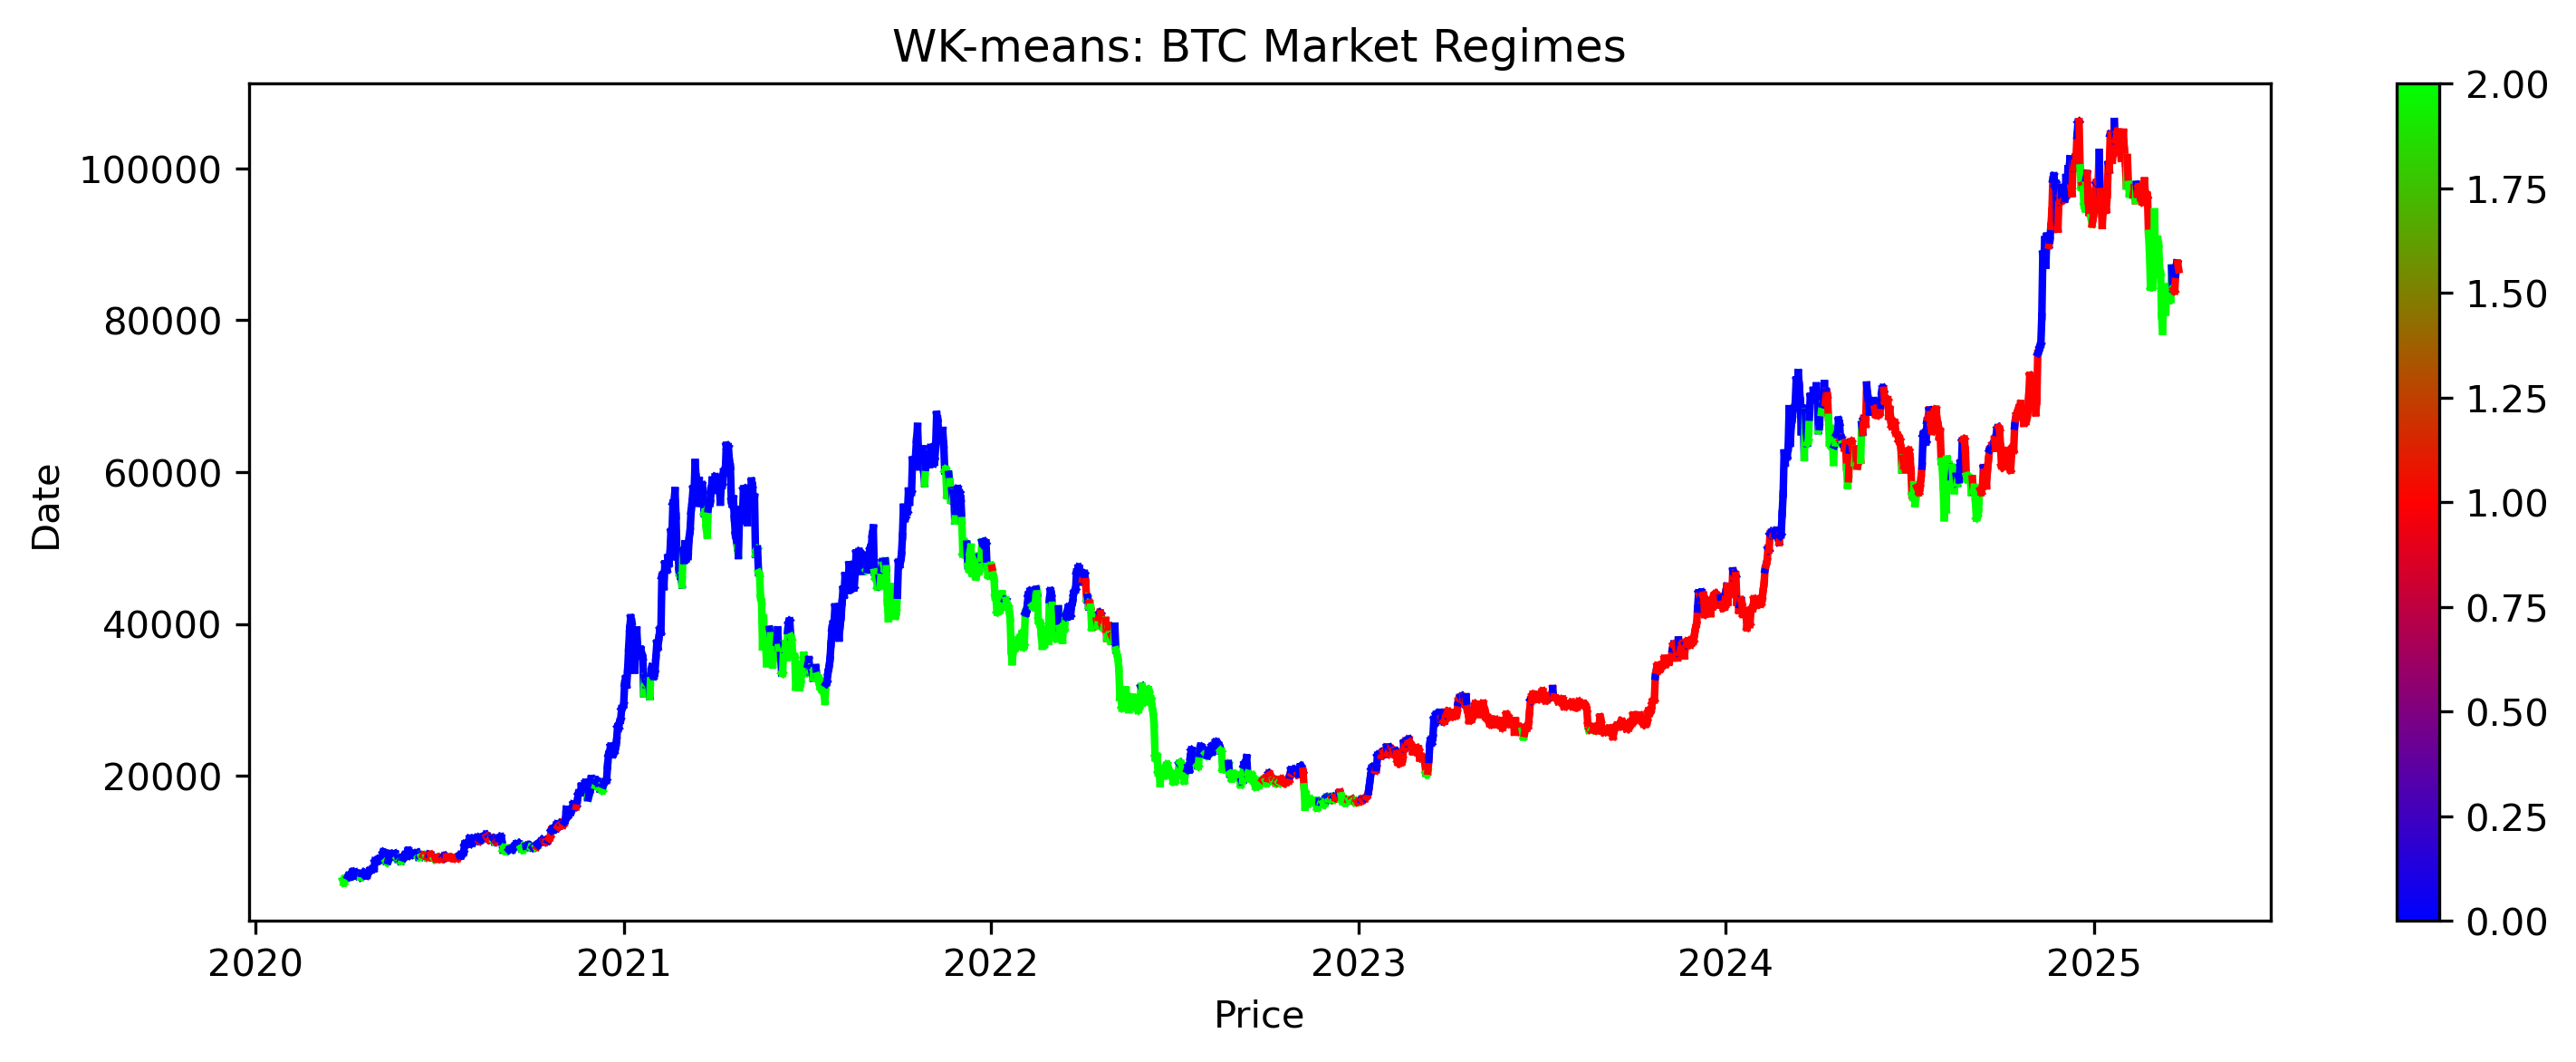

In [10]:
df = pd.concat([df, df_features['wk']], axis=1)

n = len(df)
# Normalize color values for better visualization
norm = plt.Normalize(df['wk'].min(), df['wk'].max())
cmap = plt.cm.brg # Choose a colormap (e.g., 'viridis', 'coolwarm', 'jet')

# Plot line with dynamic coloring
fig, ax = plt.subplots(dpi=300, figsize=(12, 4))
for i in range(0, n - 1):
    ax.plot(df[('Close', 'BTC-USD')][i:i+2], color=cmap(norm(df['wk'][i])), linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)

# Labels and title
ax.set_xlabel("Price")
ax.set_ylabel("Date")
ax.set_title("WK-means: BTC Market Regimes")

plt.show()
